Adrian deCola

LZ Lab

PHYS 231


In [ ]:
from google.colab import drive
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import statistics as stats
import numpy as np
import pandas as pd
import os

In [ ]:
 # Mounting the drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/deCola/LZ Lab/Data/electronic_data"

Mounted at /content/drive


# Calculating $f$, the Laser Mode Spacing
To calculate the mode spacing, we will compare the time spacing between modes to the time spacing between repeating mode patterns due to the free spectral range in accordance with the following equation: $$\frac{\Delta t}{\Delta T}=\frac{f}{FSR}$$where $\Delta t$ is the time difference between two lasing mode peaks, $\Delta T$ is the time difference to reach another repeating patterns of nodes or the amount of time that represents the FSR, or Free Spectral Range, which is given as $8\ GHz$, and $f$ is the laser mode spacing. Therefore, $$f = \frac{\Delta t}{\Delta T}FSR$$This is the equation we will use to calculate the laser mode spacing. 

### Deriving Error in $f$, the Laser Node Spacing, using Error Propogation
We can caluclate an uncertainty in $f$ using error propogation:
\begin{align}
\sigma_{f}&=\sqrt{\sum_i\left(\frac{\partial f}{\partial p_i}\right)^2\sigma_{p_i}^2}\\
\sigma_{f}&=\sqrt{\left(\frac{1}{\Delta T}FSR\sigma_{\Delta t}\right)^2+\left(\frac{-\Delta t}{(\Delta T)^2}FSR\sigma_{\Delta T}\right)^2 }
\end{align}

### Grabbing and Graphing the Data

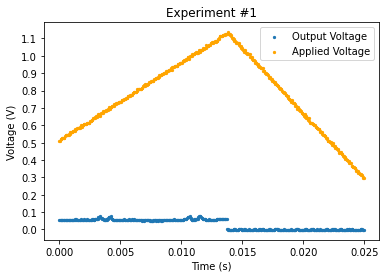

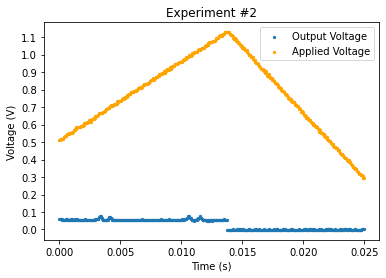

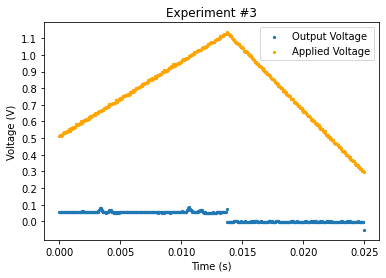

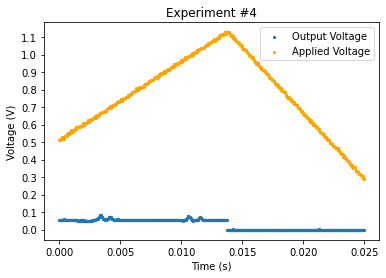

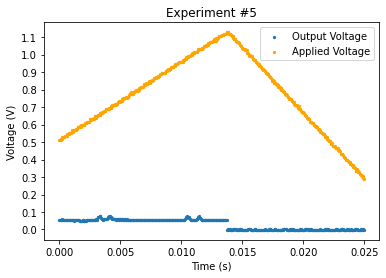

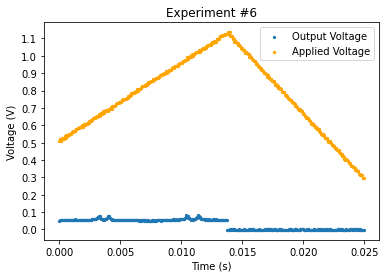

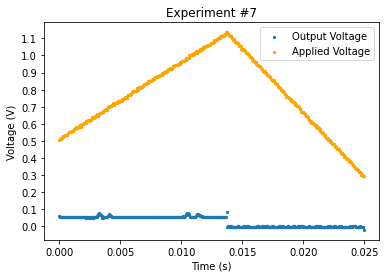

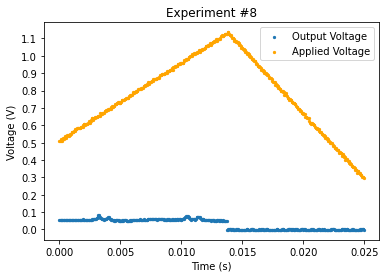

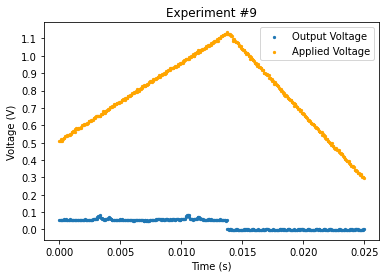

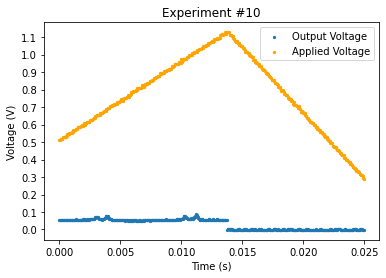

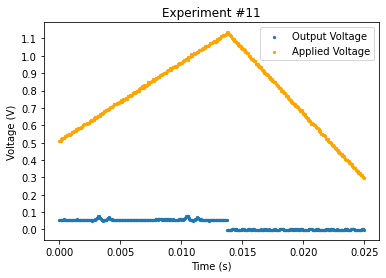

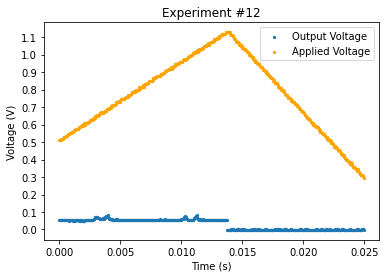

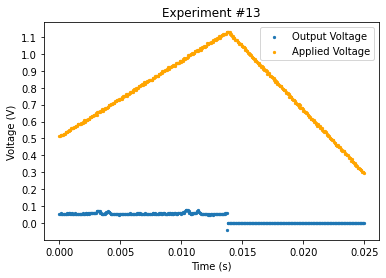

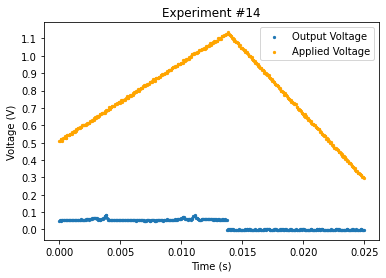

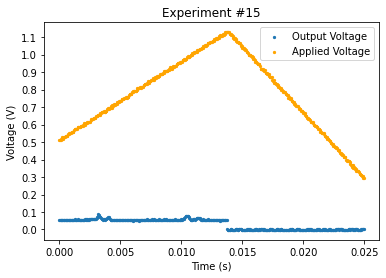

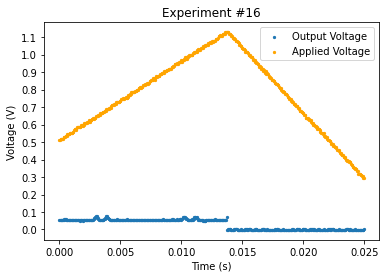

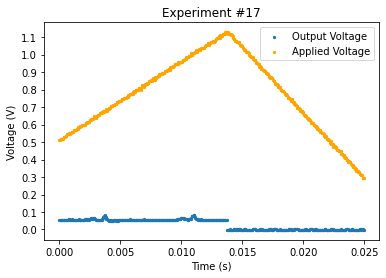

In [ ]:
node_spacing_data = data_dir + '/node_spacing_data'
i = 1 # a counter
experiment = []
times = []
voltages = []
applied_voltages = []

for file in os.listdir(node_spacing_data):
  df = pd.read_csv(os.path.join(node_spacing_data, file))
  # converting to numpy arrays
  time = df.iloc[:,0].values
  voltage = df.iloc[:,1].values
  applied_voltage = df.iloc[:,2].values
  times.append(time)
  voltages.append(voltage)
  applied_voltages.append(applied_voltage)
  experiment.append(i)

  plt.scatter(time, voltage, s=5, label = "Output Voltage")
  plt.scatter(time, applied_voltage, s=5, color = 'orange', label = "Applied Voltage")
  
  plt.legend()
  plt.title(f"Experiment #{i}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.yticks(np.arange(0, 1.2, .1))
  plt.show()


  i += 1

This is what the collected data looks like. It is clear that we are only concerned with the data where the the applied voltage, or the cavity length of the Farby-Perot spectrum analyser, is increasing, which is during the same period for each experiment. This appears to happen until about, 0.0125 seconds, or for the first half of the collected data. Since none of our modes are close to this cutoff, this estimate is sufficient and we will drop data past this point. 

In [ ]:
# making sure we don't drop data twice if this block of code is run again by accident
if len(times[0]) > 250:
  for i in range(len(times)):
    # Since the times go to about 0.025, we can drop the second half of the data. 
    times[i] = times[i][0:int(len(times[i])/2)]
    voltages[i] = voltages[i][0:int(len(voltages[i])/2)]
    applied_voltages[i] = applied_voltages[i][0:int(len(applied_voltages[i])/2)]

Lets get an idea of what the cleaned data looks like, and the peaks we are trying to estimate.

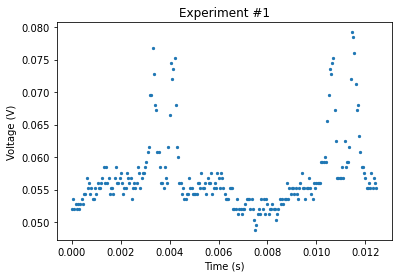

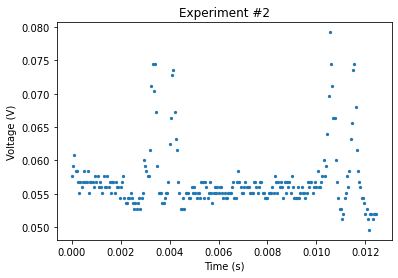

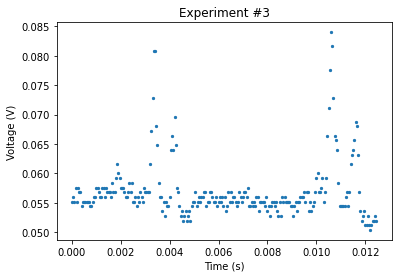

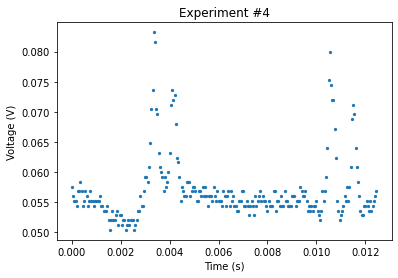

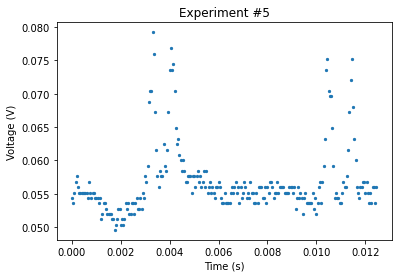

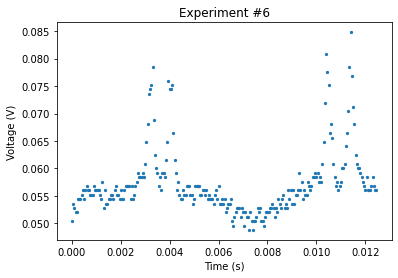

In [ ]:
# graphing the cleaned data to get an idea of what we are fitting
for i in range(len(times)):
  plt.scatter(times[i], voltages[i], s=5)
  plt.title(f"Experiment #{experiment[i]}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.show()

It's clear here that the peaks, if the data is not too noise, should have a prominence of about 0.01 V. We will find these peaks for each experiment and if there are any experments for which the peaks cannot be found, we will drop them as they were likely too noisy to begin with. 

In [ ]:
peak_times = []
peak_voltages = [] 
# redefining experiments so that we can only keep the ones where we can reliably find peaks
experiments = []
for i in range(len(times)):
  # finding peak indexes
  peak_index = find_peaks(voltages[i], prominence = 0.01)[0]
  # making sure 4 peaks were found
  if len(peak_index) == 4:
    # finding the peak times and voltages and putting them in a list
    peak_times.append([times[i][peak_index[j]] for j in range(4)])
    peak_voltages.append([voltages[i][peak_index[j]] for j in range(4)])
    experiments.append(i+1)


Now let's look at the peaks found and how close they are to the peaks we would expect by eye. 

In [ ]:
for i in range(len(experiments)):
  plt.scatter(times[experiments[i]-1], voltages[experiments[i]-1], s=2, label = "Data")
  plt.scatter(peak_times[i], peak_voltages[i], s = 40, label = "Calculated Peaks")

  plt.legend(loc = 'lower right')
  plt.title(f"Experiment #{experiments[i]}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.show()

It appear that, on average, these calculated peaks are off by usually no more than possibly two data points. Since each data point is seperated by $5*10^{-5}s$, I will assume an uncertainty in each estimated peak of $\pm 1 * 10^{-4}s$. It is also clear that for each experiment we can discern multiple calculations for the laser node spacing. As not to overdue the amount of observations we get per experiment, as likely within each experiments the same types of errors can occur, we will only consider two calculations per experiment: the calculated time difference between the first two lasing modes as compared with time difference corresponding to the free specral range using the first mode and the calculated time difference between the second two lasing modes as compared with the time difference corresponding to the free spectral range using the second mode. 

In [ ]:
# calculating the mode spacing values
f = []
delta_t = []
delta_T = []
for i in range(len(peak_times)):
  # the first mode spacing calculation
  delta_t_val = peak_times[i][1] - peak_times[i][0]
  delta_T_val = peak_times[i][2] - peak_times[i][0]
  delta_t.append(delta_t_val)
  delta_T.append(delta_T_val)
  f_val = delta_t_val/delta_T_val * 8*10**9 
  f.append(f_val)
  # the second mode spacing calculation
  delta_t_val = peak_times[i][3] - peak_times[i][2]
  delta_T_val = peak_times[i][3] - peak_times[i][1]
  delta_t.append(delta_t_val)
  delta_T.append(delta_T_val)
  f_val = delta_t_val/delta_T_val * 8*10**9 
  f.append(f_val)

Since the uncertainty in each time value for each peak is $\pm 1 * 10^{-4} s $ and each time difference is a linear combination of times, these uncertainties will add in quadrature to get the uncertainty in any time difference. $$\sigma_{\Delta t} = \sigma_{\Delta T} = \sqrt{(1*10^{-4})^2 +(1*10^{-4})^2  } =1.4* 10^{-4}s$$

In [ ]:
delta_t_unc = delta_T_unc = np.sqrt( (1*10**-4)**2 + (1*10**-4)**2)

fsr = 8 * 10**9

delta_t = np.asarray(delta_t)
delta_T = np.asarray(delta_T)
f = np.asarray(f)

# calculating the uncertainty in the mode spacing calculations
f_unc = np.sqrt( (fsr*delta_t_unc/delta_T)**2 + (-delta_t*fsr*delta_T_unc/(delta_T)**2)**2 )

### Graphing

In [ ]:
calculation = [i+1 for i in range(len(f))]

plt.scatter(calculation, f)
plt.errorbar(calculation, f, yerr=f_unc, linestyle = '')

plt.title("Laser Mode Spacing Calculations")
plt.xlabel("Calculation")
plt.ylabel("Laser Node Spacing (10^9 Hz)")

plt.show()

### Calculating a Weighted Average Value for the Laser Mode Spacing
To get a best value and uncertainty for the laser mode spacing we will use the typical method of weighting each value by their uncertainty as shown in the equation below:
 $$f = \frac{\sum_i\frac{f_i}{\sigma_{f}^2}}{\sum_i\frac{1}{\sigma_{f}^2}}$$
 With an uncertainty according to the following equation:
 $$\sigma_{f} = \left( \sqrt{\sum_i\frac{1}{\sigma_{f_i}^2}}\right)^{-1}$$

In [ ]:
f_weight = (np.sum(f/f_unc**2))/(np.sum(1/f_unc**2))
f_weight_unc = (np.sum(1/f_unc**2))**-.5

print(f"The weighted average laser mode spacing is {round(f_weight)}Hz.")
print(f"The uncertainty in this value is {round(f_weight_unc)}Hz")

The weighted average value of the laser mode spacing is $$f= (9.5\pm0.3)*10^{8}Hz$$

### Calculating a Value for $f$, the Laser Mode Spacing using the Spread Method

In [ ]:
f_spread = stats.mean(f)
f_spread_unc = stats.stdev(f) / np.sqrt(len(f)) 

print(f"The laser mode spacing calculated value using the spread method is {round(f_spread)}Hz with an uncertainty in this value of {round(f_spread_unc)}Hz.")

The spread calculated value of the laser mode spacing is $$f= (9.5\pm0.2)*10^{8}Hz$$

## Calculating the Length of the Laser Cavity from the Laser Mode Spacing
As we know, $$n\frac{\lambda_n}{2} = L$$where $L$ is the length of the laser cavity and $\lambda_n$ is the possible wavelengths that forms a standing wave and therefore that can lase. Substituting $\lambda_n= \frac{c}{f_n}$:
$$\frac{nc}{2f_n}=L$$
We know that the laser modes spacing is equal to the frequency of the lasing light divided by its corresponding mode: $$f=\frac{f_n}{n}$$Therefore, $$L=\frac{c}{2f}$$
Using error propagation the uncertainty in this value is 
\begin{align}
\sigma_{L}&=\sqrt{\sum_i\left(\frac{\partial L}{\partial p_i}\right)^2\sigma_{p_i}^2}\\
\sigma_{L}&=\frac{c\sigma_f}{2f^2}
\end{align}
We will use the weighted average, by error, value for the laser mode spacing $f= (9.5\pm0.3)*10^{8}Hz$.

In [ ]:
c= 299792458
L = c/ (2*f_weight)

L_unc = c * f_weight_unc / (2 * f_weight**2)

print(f"The laser cavity length is {round(L, 2)}m with an uncertainties in this value of {round(L_unc, 2)}m.")

The laser cavity length is 0.16m with an uncertainties in this value of 0.01m.


The laser cavity length calculated using the laser mode spacing is $L = (16\pm 1)cm$.

# Calculating the Width of the Gain Curve


To calculate the width of the gain curve, similar to calculating the laser mode spacing, we will compare the time spacing between start and end of each gain curves (as there is a clear start and end) to the time spacing between repeating gain curves due to the free spectral range in accordance with the following equation: $$\frac{\Delta t}{\Delta T}=\frac{w}{FSR}$$where $\Delta t$ is the time difference between start and end of each gain curves, $\Delta T$ is the time difference to repeated gain curves, and $w$ is width of the gain curve, as a range of frequencies. Therefore, $$w = \frac{\Delta t}{\Delta T}FSR$$Where the Free Spectral Range is given as $8*10^9Hz$. This is the equation we will use to calculate the laser mode spacing. 

### Deriving Error in $w$, the Width of the Gain Curve, using Error Propogation
We can caluclate an uncertainty in $w$ using error propogation:
\begin{align}
\sigma_{w}&=\sqrt{\sum_i\left(\frac{\partial w}{\partial p_i}\right)^2\sigma_{p_i}^2}\\
\sigma_{w}&=\sqrt{\left(\frac{1}{\Delta T}FSR\sigma_{\Delta t}\right)^2+\left(\frac{-\Delta t}{(\Delta T)^2}FSR\sigma_{\Delta T}\right)^2 }
\end{align}

### Grabbing ang Graphing the Data

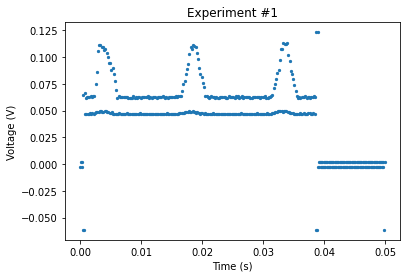

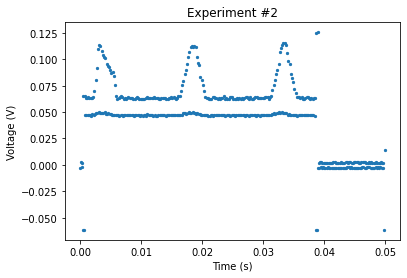

500


In [ ]:
gain_data =  data_dir + '/gain_data'
gain_times = []
gain_voltages = []
gain_experiment = []

i = 1
for file in os.listdir(gain_data):
  df = pd.read_csv(os.path.join(gain_data, file))
  # converting to numpy arrays
  gain_time = df.iloc[:,0].values
  gain_voltage = df.iloc[:,1].values

  gain_times.append(gain_time)
  gain_voltages.append(gain_voltage)
  gain_experiment.append(i)

  plt.scatter(gain_time, gain_voltage, s=5)
  plt.title(f"Experiment #{i}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")

  plt.show()
  i += 1
print(len(gain_times[0]))

### Cleaning and Graphing the Cleaned Data
Since the first gain curve in each experiment was not seen on the oscilloscope and it looks messier than the others, we will not consider it. In addition, each curve has a 'phantom curve' below it due to when the applied triangle voltage applied to the PZT is decreasing, we do not want this data and will drop it as well. 

In [ ]:
# making sure we don't drop data twice if this block of code is run again by accident
# cleaning bad gain curve
if len(gain_times[0]) == 500:
  for i in range(len(gain_times)):
    gain_times[i] = gain_times[i][int(len(gain_times[i])*3/10):int(len(gain_times[i])*3/4)]
    gain_voltages[i] = gain_voltages[i][int(len(gain_voltages[i])*3/10):int(len(gain_voltages[i])*3/4)]

  # removing second 'phantom line'
  clean_gain_times = [[],[]]
  clean_gain_voltages = [[], []]

  for i in range(len(gain_times)):
    for j in range(len(gain_times[i])):
      if gain_voltages[i][j] >0.055:
        clean_gain_times[i].append(gain_times[i][j])
        clean_gain_voltages[i].append(gain_voltages[i][j])

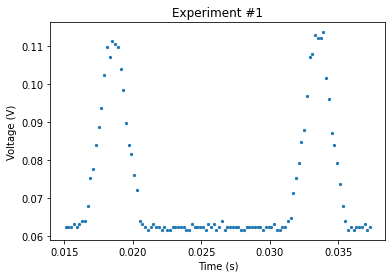

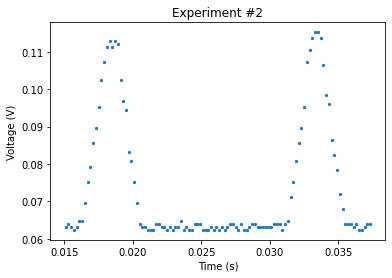

In [ ]:
# graphing the cleaned data
for i in range(len(clean_gain_times)):
  plt.scatter(clean_gain_times[i], clean_gain_voltages[i], s=5)
  plt.title(f"Experiment #{experiment[i]}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.show()

### Estimating the Base Points of each Gain Curve
To calculate the width of the gain curve we need estimate the base point of each curve. 

In [ ]:
estimated_indexes = [[7, 29, 81, 104], [6, 28, 81, 103]]
base_voltages = [[], []]
base_times = [[], []]

for i in range(len(clean_gain_voltages)):
  for j in range(4):
    base_voltages[i].append(clean_gain_voltages[i][estimated_indexes[i][j]-1])
    base_times[i].append(clean_gain_times[i][estimated_indexes[i][j]-1])
    

Let's look at our estimated base points. 

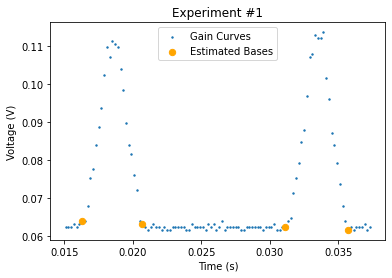

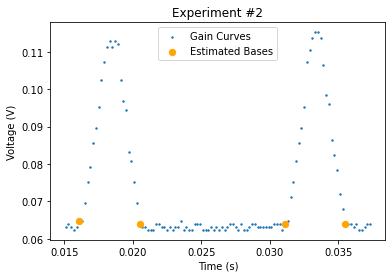

In [ ]:
# graphing the gaincures with their estimated base points
for i in range(len(clean_gain_times)):
  plt.scatter(clean_gain_times[i], clean_gain_voltages[i], s=2, label = 'Gain Curves')
  plt.scatter(base_times[i], base_voltages[i], s = 40 , label = 'Estimated Bases', color = 'orange' )
  plt.legend()
  plt.title(f"Experiment #{experiment[i]}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.show()

The uncertainty in this each estimated base point is about $\pm$ 1 data point, as it could be anywhere between the prior and next data point. As each data point is seperated by $0.002$ seconds, the uncertainty in each estimated base time is $0.002$ seconds. Once again, it is also clear that for each experiment we can discern multiple calculations for the gain curve width. As not to overdue the amount of observations we get per experiment, as likely within each experiments the same types of errors can occur, we will only consider two calculations per experiment: the calculated gain width of the first curve using the time difference in the begining of each gain curve to represent the Free Spectral Range and the calculated gain width of the second curve using the time difference in the end of each gain curve to represent the Free Spectral Range. 

In [ ]:
# calculating the gain width
w = []
delta_t = []
delta_T = []
for i in range(len(estimated_indexes)):
  # the gain width calculation
  delta_t_val = base_times[i][1] - base_times[i][0] 
  delta_T_val = base_times[i][2] - base_times[i][0]
  delta_t.append(delta_t_val)
  delta_T.append(delta_T_val)
  w_val = delta_t_val/delta_T_val * 8*10**9 
  w.append(w_val)
  # the second gain width calculation
  delta_t_val = base_times[i][3] - base_times[i][2] 
  delta_T_val = base_times[i][3] - base_times[i][1]
  delta_t.append(delta_t_val)
  delta_T.append(delta_T_val)
  w_val = delta_t_val/delta_T_val * 8*10**9 
  w.append(w_val)

Since the uncertainty in each time value for each peak is $\pm 10^{-4} s$ and each time difference is a linear combination of times, these uncertainties will add in quadrature to get the uncertainty in any time difference. $$\sigma_{\Delta t} = \sigma_{\Delta T} = \sqrt{(0.0001)^2 +(0.0001)^2  } =1.4*10^{-4}s$$

In [ ]:
delta_t_unc = delta_T_unc = np.sqrt( (.0001)**2 + (.0001)**2)

fsr = 8 * 10**9

delta_t = np.asarray(delta_t)
delta_T = np.asarray(delta_T)
w = np.asarray(w)

# calculating the uncertainty in the mode spacing calculations
w_unc = np.sqrt( (fsr*delta_t_unc/delta_T)**2 + (-delta_t*fsr*delta_T_unc/(delta_T)**2)**2 )


### Graphing

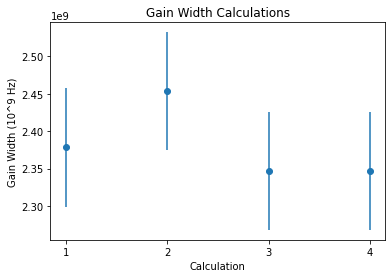

In [ ]:
calculation = [i+1 for i in range(len(w))]

plt.scatter(calculation, w)
plt.errorbar(calculation, w, yerr=w_unc, linestyle = '')

plt.title("Gain Width Calculations")
plt.xlabel("Calculation")
plt.ylabel("Gain Width (10^9 Hz)")
plt.xticks(np.arange(1, 4.1, 1))

plt.show()

### Calculating a Weighted Average Value for the Gain Curve Width
To get a best value and uncertainty for the gain curve width we will use the typical method of weighting each value by their uncertainty as shown in the equation below:
 $$f = \frac{\sum_i\frac{f_i}{\sigma_{f}^2}}{\sum_i\frac{1}{\sigma_{f}^2}}$$
 With an uncertainty according to the following equation:
 $$\sigma_{w} = \left( \sqrt{\sum_i\frac{1}{\sigma_{w_i}^2}}\right)^{-1}$$

In [ ]:
w_weight = (np.sum(w/w_unc**2))/(np.sum(1/w_unc**2))
w_weight_unc = (np.sum(1/w_unc**2))**-.5

print(f"The weighted average gain curve width is {round(w_weight)}Hz.")
print(f"The uncertainty in this value is {round(w_weight_unc)}Hz")

The weighted average gain curve width is 2381149102Hz.
The uncertainty in this value is 39478893Hz


The weighted average value of the width of the gain curve, as a range of frequencies, is $$w= (2.38\pm0.04)*10^{9}Hz$$

### Calculating a Value for $w$, the Width of the Gain Curve using the Spread Method

In [ ]:
w_spread = stats.mean(w)
w_spread_unc = stats.stdev(w) / np.sqrt(len(w)) 

print(f"The gain curve width calculated value using the spread method is {round(w_spread)}Hz with an uncertainty in this value of {round(w_spread_unc)}Hz.")

The gain curve width calculated value using the spread method is 2381261261Hz with an uncertainty in this value of 25159933Hz.


The spread calculated width of the gain curve, as a range of frequencies, is $$w= (2.38\pm0.03)*10^{9}Hz$$ This is number is further explained in the Conclusions Section. 

# Calculating the Speed of the Fastest Lasing Atoms
Calculating the speed of the fastest lasing atom we will consider the frequency shift from the Doppler Effect. $$f'=f\frac{c}{c\pm v}$$Where $f'$ is the detected frequency of one photon with its source moving at a speed $v$ relative to the Fabry-Perot interferometer and $f$ is the frequency of the photon when its source is not moving relative to the interferometer. The value for the wavelength of a Helium-Neon laser is $632.8 nm$. There is uncertainty in this value; however it is relatively much smaller that the uncertainty estimated width of the gain curve, so we will treat it as an exact value. From this wavelength the frequency of this light can be calculated, when the source atoms are not moving relative the the Fabry-Perot Spectral Analyser.$$f=\frac{c}{\lambda}$$ Let's consider the maximum frequency viewed: 
\begin{align}
f_{max}&=\frac{c}{\lambda} \frac{c}{c-v_{max}}
\end{align}
We also know that this max frequency is the equilibruim frequency when the atoms are not moving relative to the detector plus half of the gain curve width. $$f_{max} = f+\frac{1}{2} w$$Simplifying we get:    
\begin{align}
f + \frac{1}{2}w&=\frac{c}{\lambda}\frac{c}{c-v_{max}}\\
c-v_{max}&=\frac{c^2}{\lambda (f + \frac{1}{2}w)}\\ 
v_{max} &= c - \frac{c^2}{\lambda (\frac{c}{\lambda} + \frac{1}{2}w)}
\end{align}
Using error propogation the uncertainty in this value is 
\begin{align}
\sigma_{v_{max}}&=\sqrt{\sum_i\left(\frac{\partial v_{max}}{\partial p_i}\right)^2\sigma_{p_i}^2}\\
\sigma_{v_{max}}&=\frac{c^2}{2\lambda (\frac{c}{\lambda} + \frac{1}{2}w)^2}\sigma_{v_{max}}
\end{align}

In [ ]:
lambda_ = 632.8 * 10**-9

v_max = c -c**2/(lambda_*(c/lambda_ + .5*w))

v_max_unc = c**2/(2*lambda_*(c/lambda_ + .5*w)**2)*w_unc


### Graphing


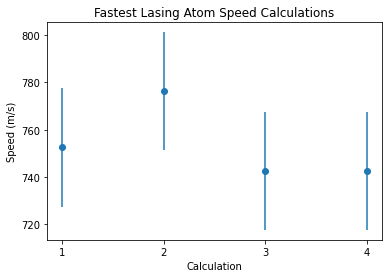

In [ ]:
calculation = [i+1 for i in range(len(v_max))]

plt.scatter(calculation, v_max)
plt.errorbar(calculation, v_max, yerr=v_max_unc, linestyle = '')

plt.title("Fastest Lasing Atom Speed Calculations")
plt.xlabel("Calculation")
plt.ylabel("Speed (m/s)")
plt.xticks(np.arange(1, 4.1, 1))

plt.show()

### Calculating a Weighted Average Value for the Fastest Lasing Atom Speed
To get a best value and uncertainty for the fastest lasing atom speed we will use the typical method of weighting each value by their uncertainty as shown in the equation below:
 $$v_{max} = \frac{\sum_i\frac{v_{max,i}}{\sigma_{v_{max,i}}^2}}{\sum_i\frac{1}{\sigma_{v_{max,i}}^2}}$$
 With an uncertainty according to the following equation:
 $$\sigma_{v_{max}} = \left( \sqrt{\sum_i\frac{1}{\sigma_{v_{max,i}}^2}}\right)^{-1}$$

In [ ]:
v_max_weight = (np.sum(v_max/v_max_unc**2))/(np.sum(1/v_max_unc**2))
v_max_weight_unc = (np.sum(1/v_max_unc**2))**-.5

print(f"The weighted average speed of the fastest lasing atoms is {round(v_max_weight)} m/s.")
print(f"The uncertainty in this value is {round(v_max_weight_unc)} m/s")

The weighted average speed of the fastest lasing atoms is 753 m/s.
The uncertainty in this value is 12 m/s


The weighted average value of the speed of the fastest lasing atom is $$v_{max}= 750\pm10 \frac{m}{s}$$

### Calculating a Value for $v_{max}$, the Speed of the Fastest Lasing Atoms using the Spread Method

In [ ]:
v_max_spread = stats.mean(v_max)
v_max_spread_unc = stats.stdev(v_max) / np.sqrt(len(v_max)) 

print(f"The speed of the fastest lasing atom calculated value using the spread method is {round(v_max_spread)} m/s with an uncertainty in this value of {round(v_max_spread_unc)} m/s.")

The speed of the fastest lasing atom calculated value using the spread method is 753 m/s with an uncertainty in this value of 8 m/s.


The spread calculated value of the speed of the fastest lasing atom is $$v_{max}= 750\pm10 \frac{m}{s}$$

# Calculating the PZT Length Change per Volt
The PZT length change per Volt is in accordance with the following equation: $$l =  \frac{\Delta  L_{PZT}}{\Delta V} =  \frac{\Delta  L_{PZT}}{V_2-V_1} $$ 

We can calculate this using the resonant peaks found in Calculating the Laser Mode Spacing Section and finding the corresponding voltages. The change in PZT length that corresponds to these resonant frequencies is a half wavelength of the light entering the interferometer. In this case, $$\Delta L_{PZT} = \frac{\lambda}{2} = 316.4\ nm$$

The uncertainty in the PZT length change per volt is $$\sigma_{l}= \sqrt{\left(\frac{\Delta  L_{PZT}}{(V_2-V_1)^2}\sigma_{V_2}\right)^2 + \left( \frac{\Delta  L_{PZT}}{(V_2-V_1)^2}\sigma_{V_1}\right)^2}$$

To get uncertainties in each laser mode peak we said that uncertainty in each peak was about two data point. We will therefore assume the uncertainty in each corresponding applied voltage is by about the difference in voltage pertaining to two data point. 

In [ ]:
# grabbing correct applied voltages where there is a peak
peak_applied_voltages = []
peak_applied_voltages_unc = []
for i in range(len(times)):
  # finding peak indexes
  peak_index = find_peaks(voltages[i], prominence = 0.01)[0]
  # making sure 4 peaks were found
  if len(peak_index) == 4:
    # finding the corresponding applied voltages and putting them in a list
    peak_applied_voltages.append([applied_voltages[i][peak_index[j]] for j in range(4)])
    # finding the uncertainties in each applied voltage as an average
    peak_applied_voltages_unc.append([(applied_voltages[i][peak_index[j]+2] - applied_voltages[i][peak_index[j]-2]) / 2 for j in range(4)])


In [ ]:
# getting the estimates for the change in voltages. 
l = []
l_unc = []
delta_l_pzt = 632.8 * 10**-9 / 2
for i in range(len(peak_applied_voltages)):
  # two estimates per experiment
  l.append(delta_l_pzt / (peak_applied_voltages[i][2] - peak_applied_voltages[i][0]))
  l_unc.append( np.sqrt((delta_l_pzt / (peak_applied_voltages[i][2] - peak_applied_voltages[i][0])**2 *peak_applied_voltages_unc[i][2])**2 + 
                (delta_l_pzt /(peak_applied_voltages[i][2] - peak_applied_voltages[i][0])**2 *peak_applied_voltages_unc[i][0])**2 ))
  l.append(delta_l_pzt / (peak_applied_voltages[i][3] - peak_applied_voltages[i][1]))
  l_unc.append( np.sqrt((delta_l_pzt / (peak_applied_voltages[i][3] - peak_applied_voltages[i][1])**2 *peak_applied_voltages_unc[i][3])**2 + 
                (delta_l_pzt /(peak_applied_voltages[i][3] - peak_applied_voltages[i][1])**2 *peak_applied_voltages_unc[i][1])**2 ))

### Graphing

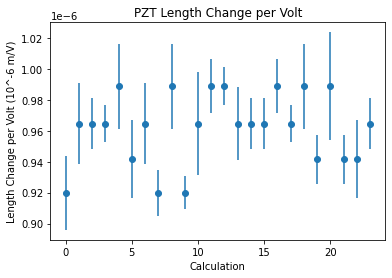

In [ ]:
calc = [i for i in range(len(l))]

plt.scatter(calc, l)
plt.errorbar(calc, l, yerr=l_unc, linestyle = '')

plt.title("PZT Length Change per Volt")
plt.xlabel("Calculation")
plt.ylabel("Length Change per Volt (10^-6 m/V)")

plt.show()

### Calculating a Weighted Average Value for the PZT Length change per folt
To get a best value and uncertainty for the gain curve width we will use the typical method of weighting each value by their uncertainty as shown in the equation below:
 $$l = \frac{\sum_i\frac{l_i}{\sigma_{l_{i}}^2}}{\sum_i\frac{1}{\sigma_{l_{i}}^2}}$$
 With an uncertainty according to the following equation:
 $$\sigma_{l} = \left( \sqrt{\sum_i\frac{1}{\sigma_{l_{i}}^2}}\right)^{-1}$$

In [ ]:
l = np.asarray(l)
l_unc = np.asarray(l_unc)

l_weight = (np.sum(l/l_unc**2))/(np.sum(1/l_unc**2))
l_weight_unc = (np.sum(1/l_unc**2))**-.5

print(f"The weighted average PZT Length Change per Volt is {round(l_weight, 9)} m/V.")
print(f"The uncertainty in this value is {round(l_weight_unc, 9)} m/V.")

The weighted average PZT Length Change per Volt is 9.58e-07 m/V.
The uncertainty in this value is 4e-09 m/V.


The weighted average value of the PZT length change per volt is $$l= (9.58\pm0.04)*10^{-7} \frac{m}{V}$$

### Calculating a PZT Length Change per Volt using the Spread Method

In [ ]:
l_spread = stats.mean(l)
l_spread_unc = stats.stdev(l) / np.sqrt(len(l)) 

print(f"The PZT length change per volt calculated value using the spread method is {round(l_spread,9)} m/V with an uncertainty in this value of {round(l_spread_unc,9)} m/V.")

The PZT length change per volt calculated value using the spread method is 9.62e-07 m/V with an uncertainty in this value of 5e-09 m/V.


The PZT length change per volt calculated using the spread method is $$l= (9.62\pm0.05)*10^{-7} \frac{m}{V}$$

# Calculating Zeeman Splitting vs B
Based on Figure 3.1, it is clear the the energy level difference, or Zeeman splitting we are trying to measure is half the energy difference between the two lasing modes. $$\Delta E = \frac{1}{2}(E_2-E_1)$$where $E_2$ and $E_1$ are the two 'split' lasing frequencies. 
Here we will talk about energy levels as frequencies, as they are directly related through Plank's constant. We are looking for the proportionality constant $X$ where $$\Delta E=X*B$$ where $B$ is the applied magnetic field. $$X = \frac{\Delta E_{2,1}}{2B}$$
where $\Delta E_{2,1}=E_2-E_1$

The uncertainty in this value is calculated as follows:    
$$\sigma_X = \sqrt{\left( \frac{\sigma_{\Delta E_{2,1}}}{2B}\right)^2 +  \left(\frac{\sigma_{B}\Delta E_{2,1}}{2B^2} \right)^2}$$



## Calculating the Energy Difference, $\Delta E_{2,1}$
To calculate the frequency or energy difference we compare the spacing to the resonant spacing, proportional to the Free Spectral Range, just like when trying to calculate the laser mode spacing: in accordance with the following equation: $$\frac{\Delta t}{\Delta T}=\frac{\Delta E_{2,1}}{FSR}$$where $\Delta t$ is the time difference between two lasing mode peaks, $\Delta T$ is the time difference to reach another repeating patterns of nodes or the amount of time that represents the FSR, or Free Spectral Range, which is given as $8\ GHz$, and $\Delta E_{2,1}$ is the energy difference between the two light producing energy drops. Therefore, $$\Delta E_{2,1} = \frac{\Delta t}{\Delta T}FSR$$This is the equation we will use to calculate the energy differency between each energy drop. 

### Deriving Error in the Energy Difference
We can caluclate an uncertainty in $\Delta E_{2,1}$ using error propogation:
\begin{align}
\sigma_{\Delta E_{2,1}}&=\sqrt{\sum_i\left(\frac{\partial \Delta E_{2,1}}{\partial p_i}\right)^2\sigma_{p_i}^2}\\
\sigma_{\Delta E_{2,1}}&=\sqrt{\left(\frac{1}{\Delta T}FSR\sigma_{\Delta t}\right)^2+\left(\frac{-\Delta t}{(\Delta T)^2}FSR\sigma_{\Delta T}\right)^2 }
\end{align}

### Grabbing and Graphing the Data

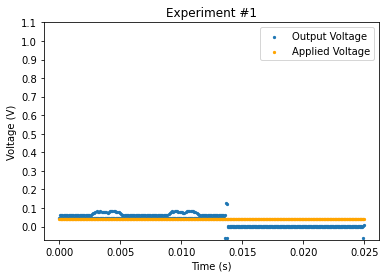

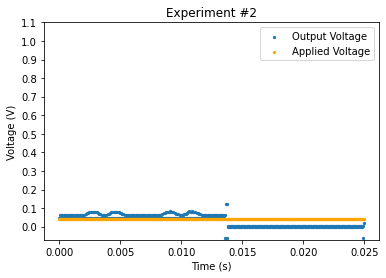

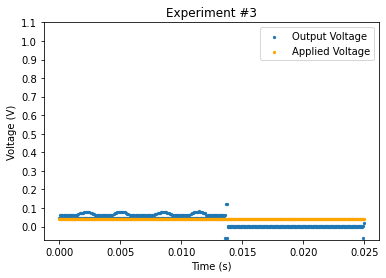

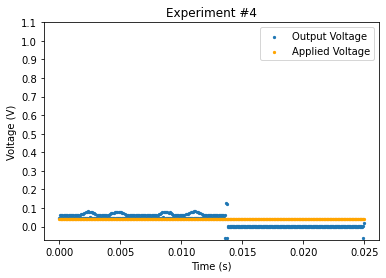

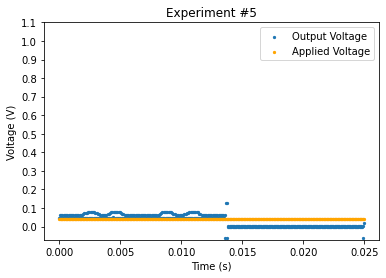

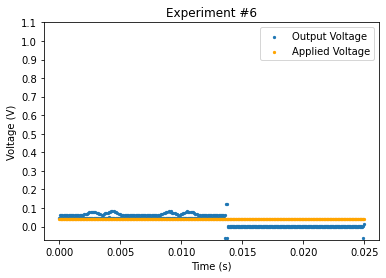

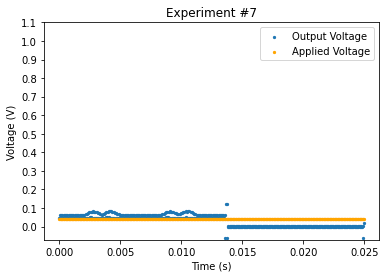

In [ ]:
zeeman_data = data_dir + '/magnet_data'
i = 1 # a counter
experiments = []
times = []
voltages = []
applied_voltages = []
applied_B = []

for file in os.listdir(zeeman_data):
  applied_B.append(int(file.strip('mag_').strip(".csv")))
  df = pd.read_csv(os.path.join(zeeman_data, file))
  # converting to numpy arrays
  time = df.iloc[:,0].values
  voltage = df.iloc[:,1].values
  applied_voltage = df.iloc[:,2].values
  times.append(time)
  voltages.append(voltage)
  applied_voltages.append(applied_voltage)
  experiment.append(i)

  plt.scatter(time, voltage, s=5, label = "Output Voltage")
  plt.scatter(time, applied_voltage, s=5, color = 'orange', label = "Applied Voltage")
  
  plt.legend()
  plt.title(f"Experiment #{i}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.yticks(np.arange(0, 1.2, .1))
  plt.show()


  i += 1

This is what the collected data looks like. It is clear that we are only concerned with the data where the the applied voltage, or the cavity length of the Farby-Perot spectrum analyser, is increasing, which is during the same period for each experiment. This appears to happen until about, 0.0125 seconds, or for the first half of the collected data. Since none of our modes are close to this cutoff, this estimate is sufficient and we will drop data past this point. 

In [ ]:
# making sure we don't drop data twice if this block of code is run again by accident
if len(times[0]) ==500:
  for i in range(len(times)):
    # Since the times go to about 0.025, we can drop the second half of the data. 
    times[i] = times[i][0:int(len(times[i])/2)]
    voltages[i] = voltages[i][0:int(len(voltages[i])/2)]
    applied_voltages[i] = applied_voltages[i][0:int(len(applied_voltages[i])/2)]
  
  clean_times = []
  clean_voltages = []
# cleaning phantom voltages from when PZT crystal is shrinking
  for i in range(len(times)):
    clean_times.append([])
    clean_voltages.append([])
    for j in range(len(times[i])):
      if voltages[i][j] >0.055: 
        clean_times[i].append(times[i][j])
        clean_voltages[i].append(voltages[i][j])


Lets get an idea of what the clean data looks like and the peaks we are trying to estimate. 

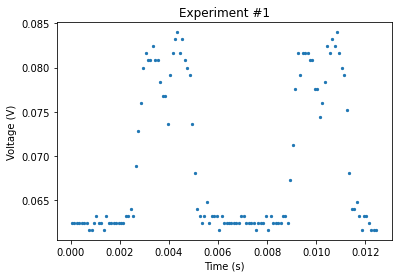

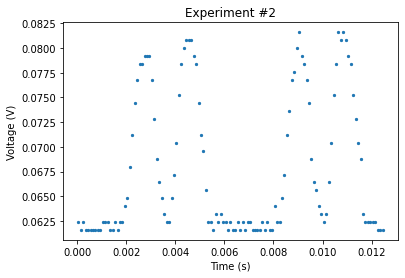

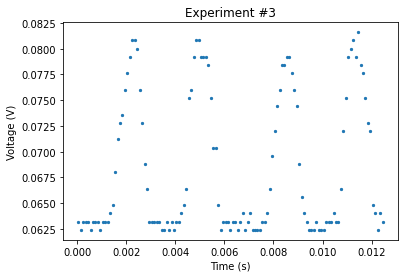

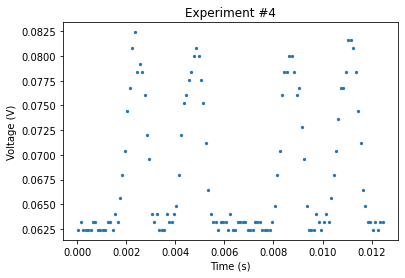

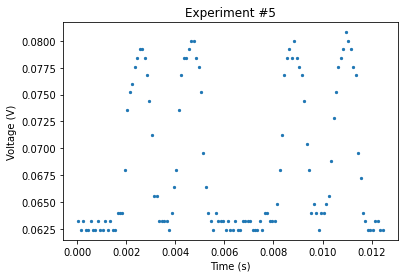

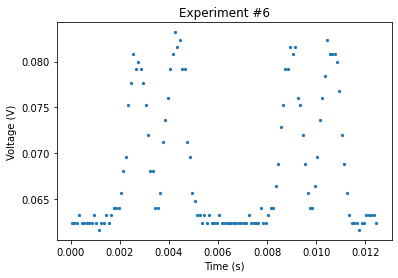

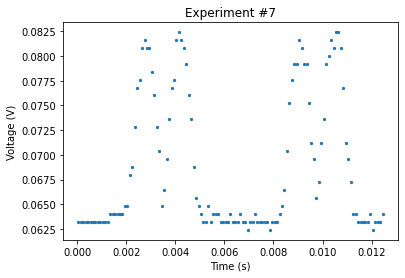

In [ ]:
# graphing the cleaned data to get an idea of what we are fitting
for i in range(len(times)):
  plt.scatter(clean_times[i], clean_voltages[i], s=5)
  plt.title(f"Experiment #{experiment[i]}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.show()

It's clear here that the peaks, if the data is not too noise, should have a prominence of about 0.01 V. We will find these peaks for each experiment and if there are any experments for which the peaks cannot be found, we will drop them as they were likely too noisy to begin with. 

In [ ]:
peak_times = []
peak_voltages = [] 
# redefining experiments so that we can only keep the ones where we can reliably find peaks
experiments = []

for i in range(len(times)):
  # finding peak indexes
  peak_index = find_peaks(clean_voltages[i], prominence = 0.01)[0]
  # making sure 4 peaks were found
  if len(peak_index) == 4:
    # finding the peak times and voltages and putting them in a list
    peak_times.append([clean_times[i][peak_index[j]] for j in range(4)])
    peak_voltages.append([clean_voltages[i][peak_index[j]] for j in range(4)])
    experiments.append(i+1)

Now let's look at the peaks found and how clost they are to the peaks we would expect by eye. 

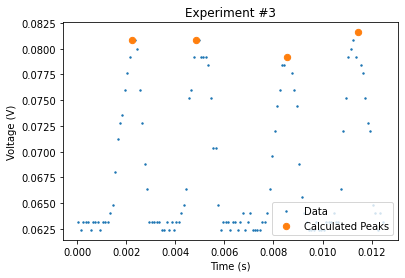

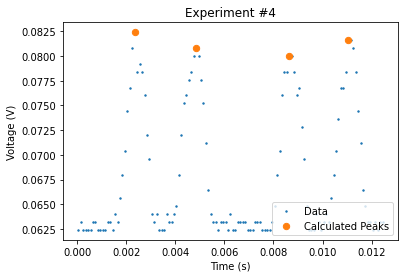

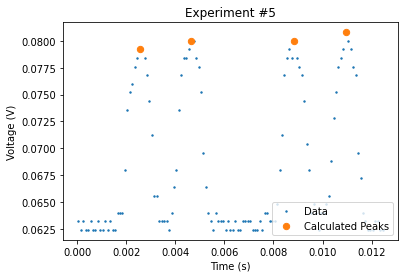

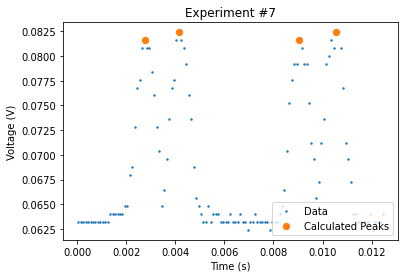

In [ ]:
for i in range(len(experiments)):
  plt.scatter(clean_times[experiments[i]-1], clean_voltages[experiments[i]-1], s=2, label = "Data")
  plt.scatter(peak_times[i], peak_voltages[i], s = 40, label = "Calculated Peaks")

  plt.legend(loc = 'lower right')
  plt.title(f"Experiment #{experiments[i]}")
  plt.xlabel("Time (s)")
  plt.ylabel("Voltage (V)")
  plt.show()

It appear that, on average, these calculated peaks are off by usually no more than one data points. Since each data point is seperated by $5*10^{-5}s$, $1*10^{-4}$ will be the uncertainty in each estimated peak time. It is also clear that for each experiment we can discern multiple calculations for the energy differences. As not to overdue the amount of observations we get per experiment, as likely within each experiments the same types of errors can occur, we will only consider two calculations per experiment: the calculated first energy difference as compared with time difference corresponding to the free specral range using the first peaks and the calculated second energy difference as compared with the time difference corresponding to the free spectral range using the second peaks. 

In [ ]:
# calculating the energy difference
delta_E = []
delta_t = []
delta_T = []
for i in range(len(peak_times)):
  # the first mode spacing calculation
  delta_t_val = peak_times[i][1] - peak_times[i][0]
  delta_T_val = peak_times[i][2] - peak_times[i][0]
  delta_t.append(delta_t_val)
  delta_T.append(delta_T_val)
  delta_E_val = delta_t_val/delta_T_val * 8*10**9 
  delta_E.append(delta_E_val)
  # the second mode spacing calculation
  delta_t_val = peak_times[i][3] - peak_times[i][2]
  delta_T_val = peak_times[i][3] - peak_times[i][1]
  delta_t.append(delta_t_val)
  delta_T.append(delta_T_val)
  delta_E_val = delta_t_val/delta_T_val * 8*10**9 
  delta_E.append(delta_E_val)

Since the uncertainty in each time value for each peak is $\pm 1 * 10^{-4} s $ and each time difference is a linear combination of times, these uncertainties will add in quadrature to get the uncertainty in any time difference. $$\sigma_{\Delta t} = \sigma_{\Delta T} = \sqrt{(1*10^{-4})^2 +(1*10^{-4})^2  } =1.4 * 10^{-4}s$$

In [ ]:
delta_t_unc = delta_T_unc = np.sqrt( (1*10**-4)**2 + (1*10**-4)**2)

fsr = 8 * 10**9

delta_t = np.asarray(delta_t)
delta_T = np.asarray(delta_T)
delta_E = np.asarray(delta_E)

# calculating the uncertainty in the mode spacing calculations
delta_E_unc = np.sqrt( (fsr*delta_t_unc/delta_T)**2 + (-delta_t*fsr*delta_T_unc/(delta_T)**2)**2 )

### Now we will callculate the Zeeman splitting vs B

In [ ]:
# building up a numpy array for the corresponding magnetic fields.
B = []
B_unc = []
for i in range(len(experiments)):
  index = experiments[i]-1
  B.append(applied_B[index])
  B.append(applied_B[index])

for i in range(len(B)):
  # the uncertainty remained the same for all experiments
  B_unc.append(2)

delta_E = np.asarray(delta_E)
B = np.asarray(B)
delta_E_unc = np.asarray(delta_E_unc)
B_unc = np.asarray(B_unc)

X = delta_E / (2*B)
X_unc = np.sqrt( (delta_E_unc/(2*B))**2 + (B_unc*delta_E/(2*B**2))**2 )


### Graphing

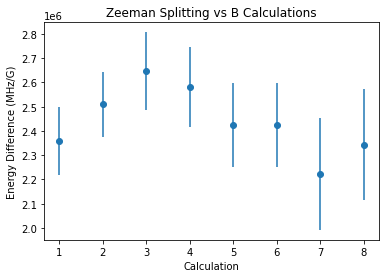

In [ ]:
calculation = [i+1 for i in range(len(X))]

plt.scatter(calculation, X)
plt.errorbar(calculation, X, yerr=X_unc, linestyle = '')

plt.title("Zeeman Splitting vs B Calculations")
plt.xlabel("Calculation")
plt.ylabel("Energy Difference (MHz/G)")

plt.show()

### Calculating a Weighted Average Value for the Zeeman Splitting vs B Value
To get a best value and uncertainty for the Zeeman splitting vs B value we will use the typical method of weighting each value by their uncertainty as shown in the equation below:
 $$X = \frac{\sum_i\frac{X_i}{\sigma_{X}^2}}{\sum_i\frac{1}{\sigma_{X}^2}}$$
 With an uncertainty according to the following equation:
 $$\sigma_{X} = \left( \sqrt{\sum_i\frac{1}{\sigma_{X_i}^2}}\right)^{-1}$$

In [ ]:
X_weight = (np.sum(X/X_unc**2))/(np.sum(1/X_unc**2))
X_weight_unc = (np.sum(1/X_unc**2))**-.5

print(f"The weighted average Zeeman splitting vs B value is {round(X_weight)} Hz/G.")
print(f"The uncertainty in this value is {round(X_weight_unc)} Hz/G")

The weighted average Zeeman splitting vs B value is 2460266 Hz/G.
The uncertainty in this value is 58812 Hz/G


The weighted average value of the Zeeman splitting vs B value is $$X= (2.46\pm0.06)*10^{6}\frac{Hz}{G}$$

### Calculating the Zeeman Splitting vs B Value using the Spread Method

In [ ]:
X_spread = stats.mean(X)
X_spread_unc = stats.stdev(X) / np.sqrt(len(X)) 

print(f"The Zeeman splitting vs B calculated value using the spread method is {round(X_spread)} Hz/G with an uncertainty in this value of {round(X_spread_unc)} Hz/G.")

The Zeeman splitting vs B calculated value using the spread method is 2438713 Hz/G with an uncertainty in this value of 48344 Hz/G.


The spread calculated value of the Zeeman splitting vs B value is $$X= (2.44\pm0.05)*10^{6}\frac{Hz}{G}$$

# Understanding the Change in Laser Cavity Length from Room Tempature while Operating
As the manually collected data shows, turning the laser on for three minutes from room tempature saw $\Delta n = 23\pm 1$ laser modes pass. As explained in the Set-up Section this is caused by the laser cavity expanding. As derived in when calculating the laser cavity length: $$\frac{nc}{2f_n}=L$$The value for the wavelength of a Helium-Neon laser is $632.8 nm$. There is uncertainty in this value; however it is relatively much smaller that the uncertainty in the amount of laser modes that passed by so we will treat it as an exact value. From this wavelength the frequency of this light, can be calculated: $$f_n = \frac{c}{\lambda}$$


In [ ]:
f_n = c/ (632.8 * 10**-9)
print(f"The frequency of the light coming from the Helium-Neon laser is {round(f_n)}Hz.")

The frequency of the light coming from the Helium-Neon laser is 473755464601770Hz.


$$f_n = 4.74 * 10 ^{14} Hz$$An expression for the change in the laser cavity over three minutes can be derived. 
\begin{align}
\frac{nc}{2f_n}&=L\\
\Delta L &= \frac{\Delta n c}{2f_n}
\end{align}
Using error propogation the uncertainty in this value is 
\begin{align}
\sigma_{\Delta L}&=\sqrt{\sum_i\left(\frac{\partial\Delta  L}{\partial p_i}\right)^2\sigma_{p_i}^2}\\
\sigma_{\Delta L}&=\frac{c\sigma_{\Delta n}}{2f_n}
\end{align}

In [ ]:
delta_n = 23
delta_n_unc = 1

change_in_L = delta_n * c / (2*f_n)
change_in_L_unc = c*delta_n_unc/(2*f_n)

print(f"The change in the laser cavity legth over three minutes from room tempature is {round(change_in_L, 7)}m with an uncertainty in this value of {round(change_in_L_unc, 7)}m.")

The change in the laser cavity legth over three minutes from room tempature is 7.3e-06m with an uncertainty in this value of 3e-07m.


The change in the laser cavity length after three minutes from room tempature is $\Delta L = (7.3 \pm 0.3)\mu m$. Meaning it grew by this amount.